# Install Dataset

# Visualize data and trainning model

In [ ]:
import os
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [ ]:
data_dir = '/content/drive/MyDrive/kaggle/tomato/train'
df = loading_the_data(data_dir)

df

filepaths  \
0     /content/drive/MyDrive/kaggle/tomato/train/Tom...   
1     /content/drive/MyDrive/kaggle/tomato/train/Tom...   
2     /content/drive/MyDrive/kaggle/tomato/train/Tom...   
3     /content/drive/MyDrive/kaggle/tomato/train/Tom...   
4     /content/drive/MyDrive/kaggle/tomato/train/Tom...   
...                                                 ...   
9995  /content/drive/MyDrive/kaggle/tomato/train/Tom...   
9996  /content/drive/MyDrive/kaggle/tomato/train/Tom...   
9997  /content/drive/MyDrive/kaggle/tomato/train/Tom...   
9998  /content/drive/MyDrive/kaggle/tomato/train/Tom...   
9999  /content/drive/MyDrive/kaggle/tomato/train/Tom...   

                       labels  
0     Tomato___Bacterial_spot  
1     Tomato___Bacterial_spot  
2     Tomato___Bacterial_spot  
3     Tomato___Bacterial_spot  
4     Tomato___Bacterial_spot  
...                       ...  
9995         Tomato___healthy  
9996         Tomato___healthy  
9997         Tomato___healthy  
9998         Tomato___healthy  
9999         Tomato___healthy  

[10000 rows x 2 columns]

In [ ]:
data_balance = df.labels.value_counts()
data_balance

labels
Tomato___Bacterial_spot                          1000
Tomato___Early_blight                            1000
Tomato___Late_blight                             1000
Tomato___Leaf_Mold                               1000
Tomato___Septoria_leaf_spot                      1000
Tomato___Spider_mites Two-spotted_spider_mite    1000
Tomato___Target_Spot                             1000
Tomato___Tomato_Yellow_Leaf_Curl_Virus           1000
Tomato___Tomato_mosaic_virus                     1000
Tomato___healthy                                 1000
Name: count, dtype: int64

In [ ]:
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [ ]:
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

In [ ]:
def get_pred(model, test_gen):

    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)

    return y_pred

In [ ]:
def conv_block(filters, act='relu'):

    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())

    return block

In [ ]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [ ]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)


train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 8000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.


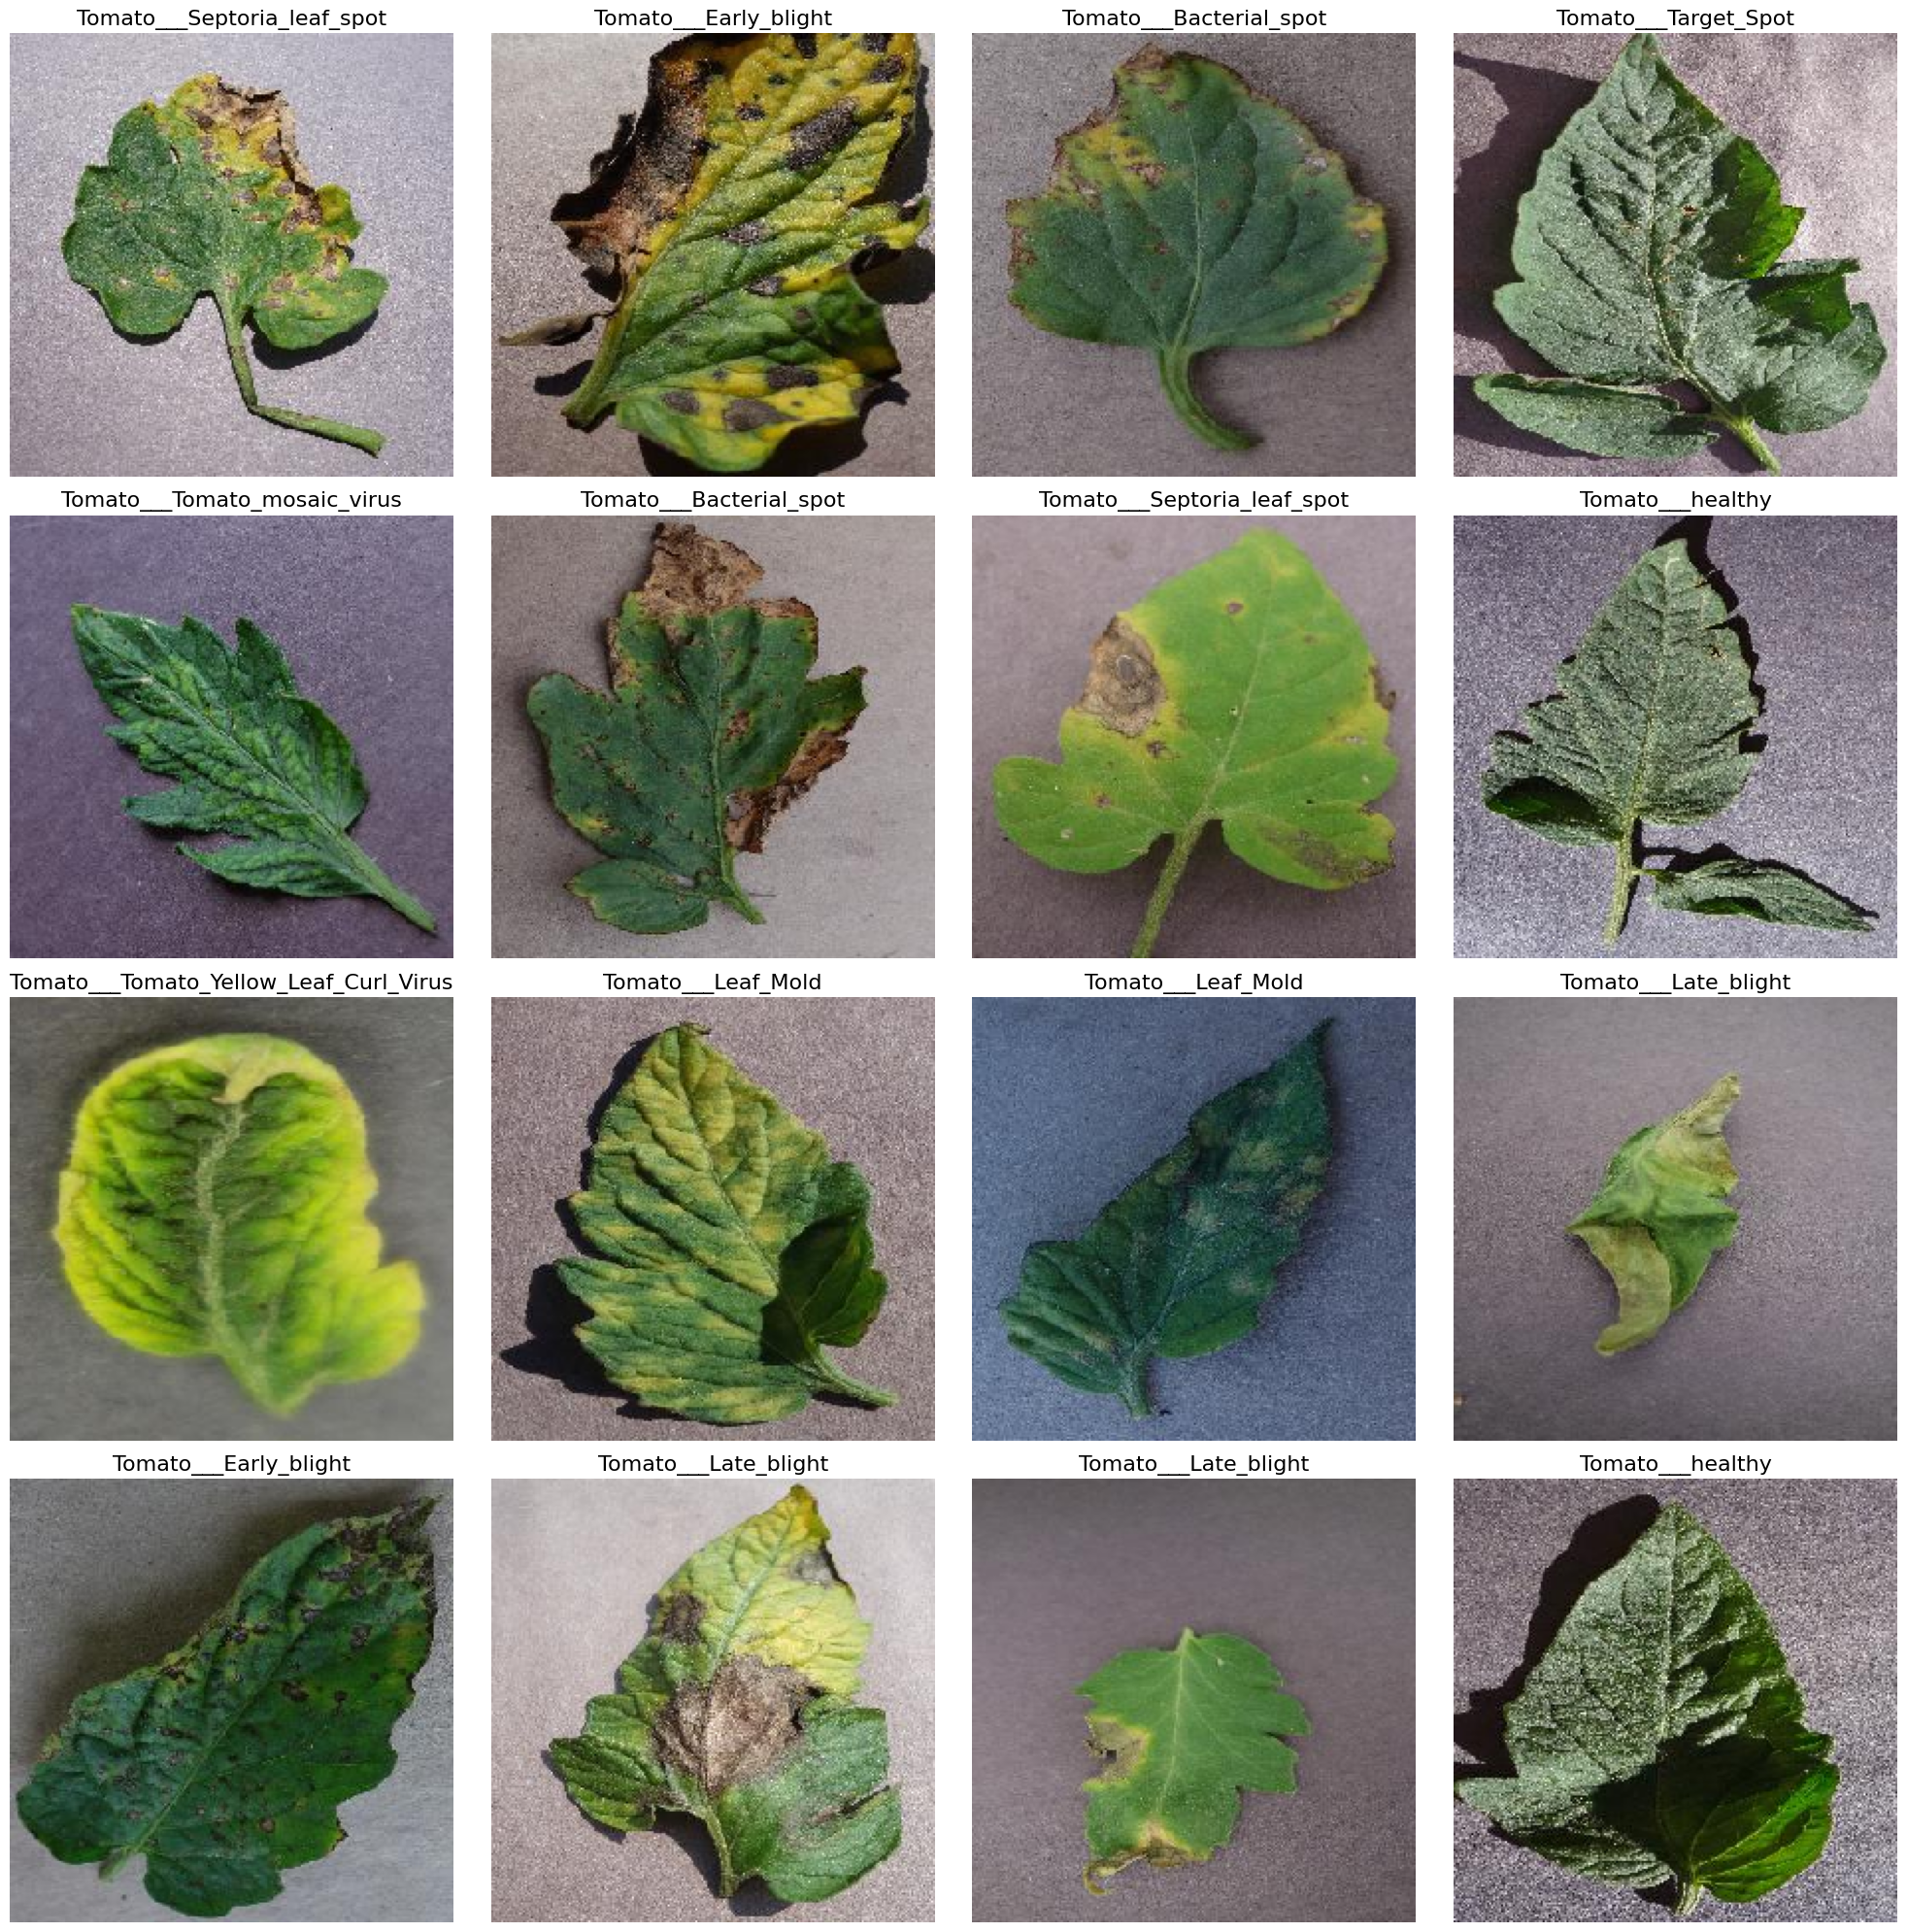

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

# ploting the patch size samples
plt.figure(figsize= (20, 20))

for i in range(batch_size):
    plt.subplot(4, 4, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def dense_block(units, dropout_rate, act='relu'):

    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))

    return block

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_counts = len(list(train_gen.class_indices.keys()))
train_gen.class_indices.keys()

dict_keys(['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'])

In [ ]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D())

cnn_model.add(conv_block(32))

cnn_model.add(conv_block(64))

cnn_model.add(conv_block(128))

cnn_model.add(conv_block(256))

cnn_model.add(conv_block(512))

cnn_model.add(Flatten())

cnn_model.add(dense_block(256, 0.5))

cnn_model.add(dense_block(128, 0.3))

cnn_model.add(dense_block(64, 0.2))

cnn_model.add(dense_block(32, 0.2))

cnn_model.add(Dense(class_counts, activation = "softmax"))

cnn_model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 224, 224, 16)      448       
                                                                 
 batch_normalization_22 (Ba  (None, 224, 224, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_87 (MaxPooli  (None, 112, 112, 16)      0         
 ng2D)                                                           
                                                                 
 sequential_41 (Sequential)  (None, 56, 56, 32)        14016     
                                                                 
 sequential_42 (Sequential)  (None, 28, 28, 64)        55680     
                                                                 
 sequential_43 (Sequential)  (None, 14, 14, 128)     

In [ ]:
# Compile the model
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20

history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
500/500 [==============================] - 61s 94ms/step - loss: 2.2879 - accuracy: 0.1915 - val_loss: 2.3788 - val_accuracy: 0.1840
Epoch 2/20
500/500 [==============================] - 45s 90ms/step - loss: 1.7484 - accuracy: 0.3704 - val_loss: 1.6834 - val_accuracy: 0.4130
Epoch 3/20
500/500 [==============================] - 48s 96ms/step - loss: 1.4795 - accuracy: 0.4761 - val_loss: 1.7665 - val_accuracy: 0.3970
Epoch 4/20
500/500 [==============================] - 46s 93ms/step - loss: 1.2730 - accuracy: 0.5560 - val_loss: 2.1172 - val_accuracy: 0.3620
Epoch 5/20
500/500 [==============================] - 47s 94ms/step - loss: 1.1294 - accuracy: 0.6198 - val_loss: 1.3578 - val_accuracy: 0.5390
Epoch 6/20
500/500 [==============================] - 47s 93ms/step - loss: 1.0392 - accuracy: 0.6456 - val_loss: 1.0511 - val_accuracy: 0.6210
Epoch 7/20
500/500 [==============================] - 48s 95ms/step - loss: 0.9362 - accuracy: 0.6837 - val_loss: 1.2238 - val_accuracy:

In [ ]:
# Save the model
cnn_model.save("my_model.h5")

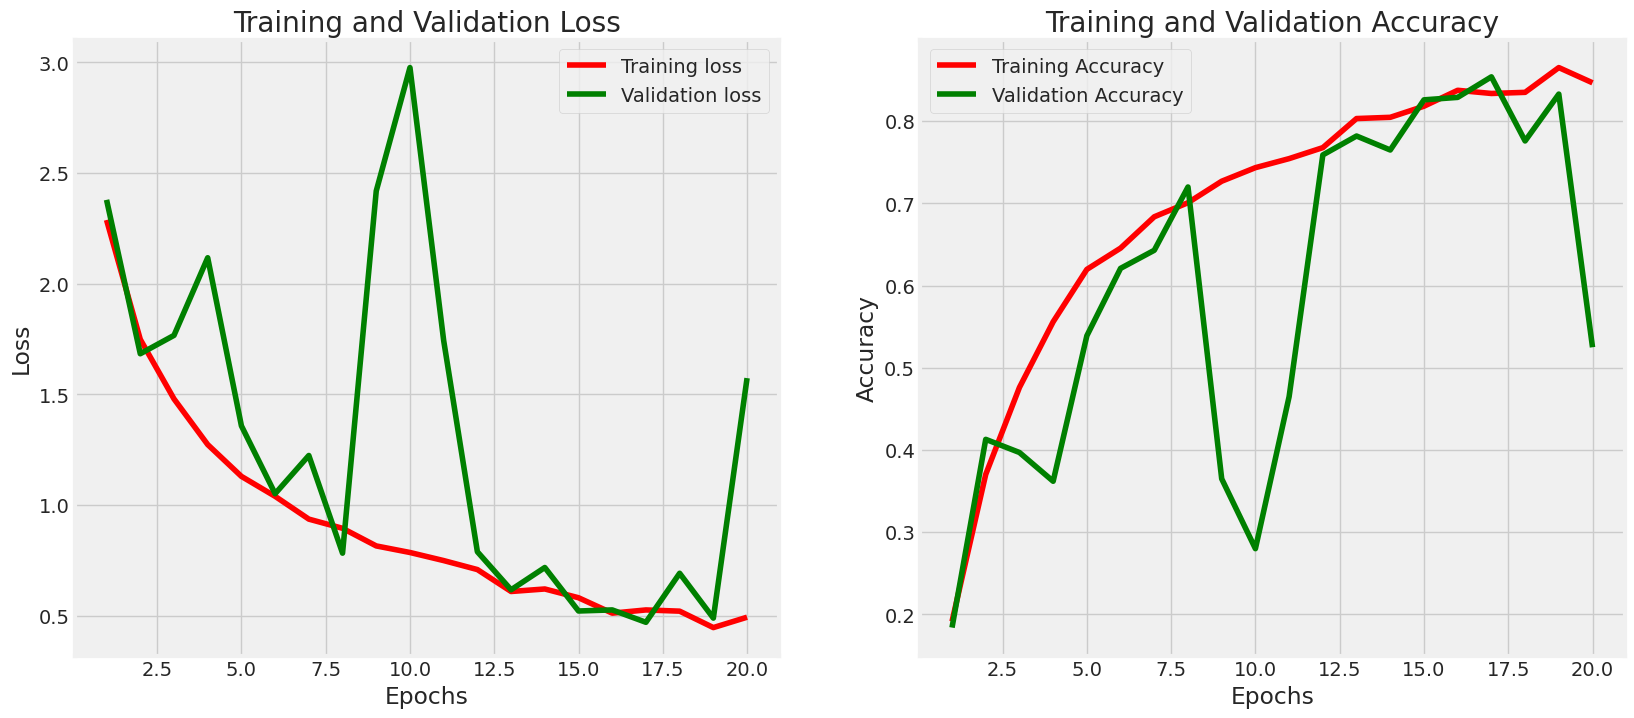

In [ ]:
model_performance(history, epochs)

In [ ]:
model_evaluation(cnn_model)

63/63 [==============================] - 5s 73ms/step - loss: 1.3920 - accuracy: 0.5650
Train Loss:  1.4297616481781006
Train Accuracy:  0.562624990940094
--------------------
Validation Loss:  1.5733201503753662
Validation Accuracy:  0.5249999761581421
--------------------
Test Loss:  1.3920440673828125
Test Accuracy:  0.5649999976158142


VGG16 Model

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape = img_shape, pooling= 'max')

for layer in base_model.layers[:15]:
    layer.trainable = False



x = base_model.output
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)   # # Dropout layer to prevent overfitting
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(32, activation = 'relu')(x)
predictions = Dense(class_counts, activation = "sigmoid")(x)    # output layer with softmax activation


VGG16_model = Model(inputs = base_model.input, outputs = predictions)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in VGG16_model.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_max_pooling2d True
flatten_17 True
dense_36 True
dropout_8 True
dense_37 True
dense_38 True
dense_39 True
dense_40 True


In [ ]:
VGG16_model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

VGG16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
epochs = 20

VGG16_history = VGG16_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
500/500 [==============================] - 64s 113ms/step - loss: 0.2562 - accuracy: 0.4700 - val_loss: 0.1349 - val_accuracy: 0.7890
Epoch 2/20
500/500 [==============================] - 49s 97ms/step - loss: 0.1146 - accuracy: 0.8164 - val_loss: 0.0866 - val_accuracy: 0.8620
Epoch 3/20
500/500 [==============================] - 51s 101ms/step - loss: 0.0722 - accuracy: 0.8896 - val_loss: 0.0581 - val_accuracy: 0.9160
Epoch 4/20
500/500 [==============================] - 49s 97ms/step - loss: 0.0509 - accuracy: 0.9274 - val_loss: 0.0478 - val_accuracy: 0.9300
Epoch 5/20
500/500 [==============================] - 49s 99ms/step - loss: 0.0368 - accuracy: 0.9511 - val_loss: 0.0474 - val_accuracy: 0.9230
Epoch 6/20
500/500 [==============================] - 50s 99ms/step - loss: 0.0277 - accuracy: 0.9650 - val_loss: 0.0382 - val_accuracy: 0.9470
Epoch 7/20
500/500 [==============================] - 50s 101ms/step - loss: 0.0211 - accuracy: 0.9751 - val_loss: 0.0355 - val_accura

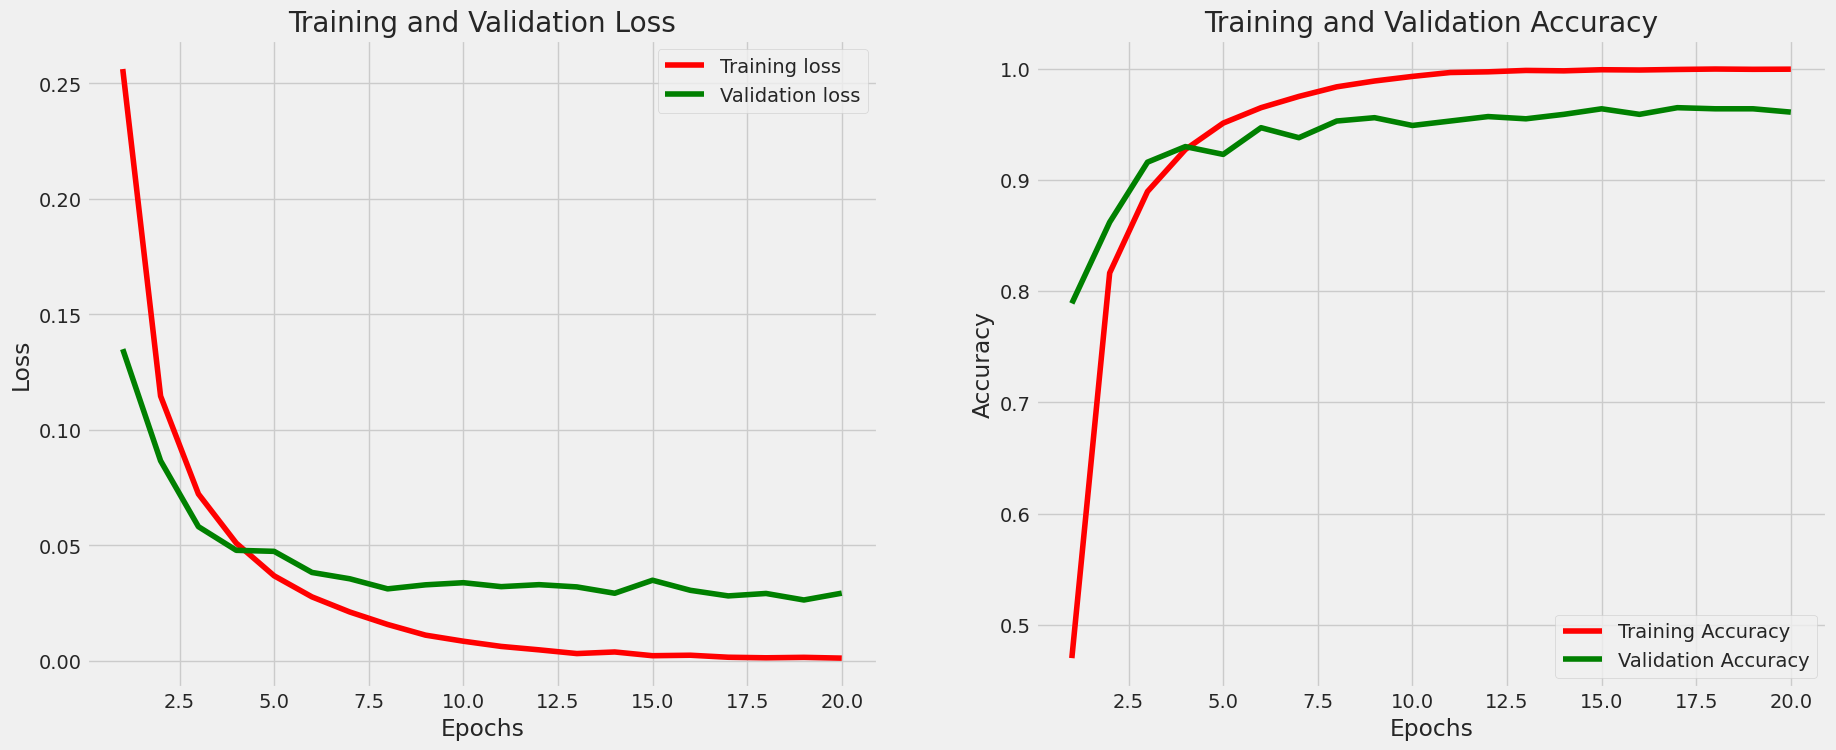

In [ ]:
model_performance(VGG16_history, epochs)

In [ ]:
model_evaluation(VGG16_model)

63/63 [==============================] - 5s 83ms/step - loss: 0.0349 - accuracy: 0.9560
Train Loss:  0.0002278682659380138
Train Accuracy:  1.0
--------------------
Validation Loss:  0.029257504269480705
Validation Accuracy:  0.9610000252723694
--------------------
Test Loss:  0.03490748628973961
Test Accuracy:  0.9559999704360962


In [ ]:
VGG16_model.save("VGG16_model.h5")

# Loadmodel

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
VGG16_model = load_model("/content/VGG16_model.h5")

# Define function to preprocess image
def preprocess_image(image):
    image = Image.fromarray(image.astype('uint8'), 'RGB')  # Convert numpy array to PIL Image
    image = image.resize((224, 224))  # Resize image to match model input shape
    image = np.array(image)  # Convert PIL Image back to numpy array
    image = image / 255.0  # Normalize pixel values
    return image